In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods):
    x1 = -0.5*L_p
    # ncy = 20

    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    
    xx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    xx_ref = torch.linspace(0, 1-1/ncx1, ncx1)
    xx[0:ncx1] = -L_p*(1 - xx_ref) + x1*xx_ref 
    xx_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    xx[ncx1:ncx1+ncx2] = x1*(1 - xx_ref) + x2 * xx_ref
    xx_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    xx[ncx1+ncx2:ncx1+ncx2+ncx3] = x2*(1 - xx_ref) + x3 * xx_ref
    xx_ref = torch.linspace(0, 1, ncx4+1)
    xx[ncx1+ncx2+ncx3:ncx1+ncx2+ncx3+ncx4+1] = x3*(1 - xx_ref) + 0*xx_ref
    
    yy = torch.zeros(ncx+1, dtype=torch.float).to(device)
    yy_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    yy[ncx1:ncx1+ncx2] = 0*(1 - yy_ref) + h*yy_ref
    yy_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    yy[ncx1+ncx2:ncx1+ncx2+ncx3] = h*(1 - yy_ref) + 0*yy_ref
    
    

    X_Y = torch.zeros((1, n_periods*ncx+1, 2), dtype=torch.float).to(device)
    X_Y[0, -(ncx + 1):, 0], X_Y[0, -(ncx + 1):, 1] = xx, yy
    for i_period in range(1,n_periods):
        X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 0], X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 1] = xx-i_period*L_p, yy
       
    
    return X_Y, xx, yy


def Theta2Mesh_1d(L_p, x2, x3, h):
    ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
    n_periods = 10
    X_Y, X, Y = catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods)
    return X_Y, X, Y

[147.           5.07216     60.09925132 -30.04962566 -24.55897923
 -15.03442615  29.89950206]
min loss =  887574.3290757302 L_p, x2, x3, h =  60.0992513178195 -24.55897922827934 -15.034426151572651 29.8995020570883


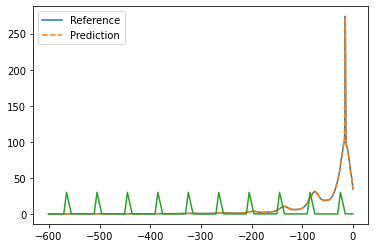

In [30]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
ncx = ncx1 + ncx2 + ncx3 + ncx4


modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x2, x3, h, press = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
    all_loss[i] = -np.dot(out,xx_mask)

    
loss_min = np.min(all_loss)
loss_min_ind = np.argmin(all_loss)
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_period_model_1d500", map_location=device)
X_Y, X, Y = catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods)
out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()

print(inputPara[:, loss_min_ind])
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out, "--", label="Prediction")
plt.plot(mesh_X, mesh_Y)
plt.legend()

In [21]:
inputPara.shape

(7, 1000)

1d X error =  2.22844987938144e-05
1d Y error =  7.89796405869595e-06
L_p, x1, x2, x3, h  =  85 -42.5 -32 -30 30
loss =  1126154.4170708358


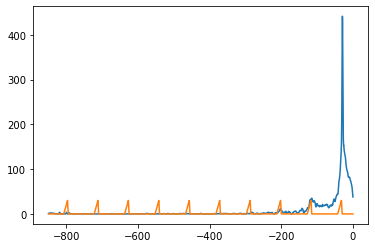

In [19]:
L_p, x2, x3, h = 85, -32, -30, 30
x1 = -0.5*L_p
n_periods = 10
ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
ncx = ncx1 + ncx2 + ncx3 + ncx4
X0,Y0 = numpy_catheter_mesh_1d_single_period(L_p, x1, x2, x3, h, ncx1, ncx2, ncx3, ncx4)
X_Y, X, Y = catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()

##################################################
# Prediction on a special design
#################################################
model = torch.load("catheter_plain_period_model_1d500", map_location=device)
out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
print("loss = ",  -np.dot(out,xx_mask) )
plt.figure()
plt.plot(xx_mask, out)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1])


82373057
0 0.058098893612623215 loss =  887574.5
L_p, x1, x2, x3, h  =  60.09925079345703 -30.049625396728516 -24.55898094177246 -15.034425735473633 29.89950180053711


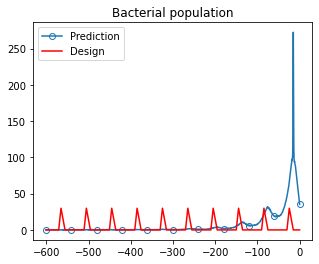

200 0.05663225054740906 loss =  866441.5
L_p, x1, x2, x3, h  =  60.099246978759766 -30.049623489379883 -24.149377822875977 -15.03470516204834 29.939311981201172


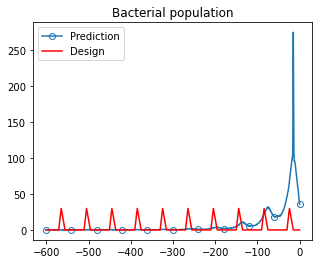

400 0.05671096034348011 loss =  859706.5625
L_p, x1, x2, x3, h  =  60.0992431640625 -30.04962158203125 -23.724088668823242 -15.03502368927002 29.93170166015625


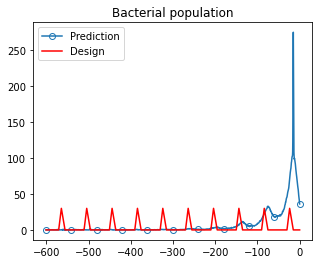

600 0.05664399545639753 loss =  863003.5
L_p, x1, x2, x3, h  =  60.099239349365234 -30.049619674682617 -23.34715461730957 -15.035385131835938 29.89618682861328


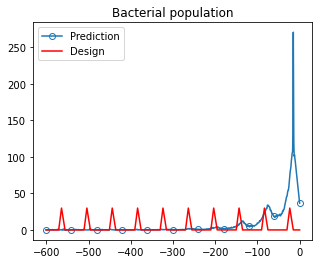

800 0.05678891483694315 loss =  870466.5
L_p, x1, x2, x3, h  =  60.09923553466797 -30.049617767333984 -23.06892204284668 -15.035684585571289 29.873249053955078


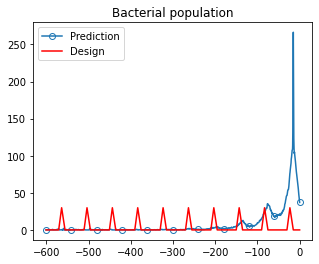

1000 0.05717933550477028 loss =  870778.9375
L_p, x1, x2, x3, h  =  60.0992317199707 -30.04961585998535 -22.977676391601562 -15.035934448242188 29.952783584594727


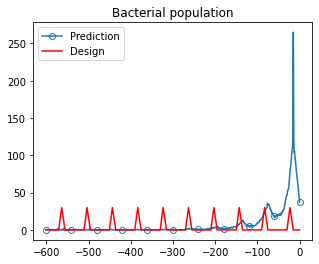

1200 0.056727709248661995 loss =  869115.8125
L_p, x1, x2, x3, h  =  60.0992317199707 -30.04961585998535 -23.06853675842285 -15.03604793548584 29.91408920288086


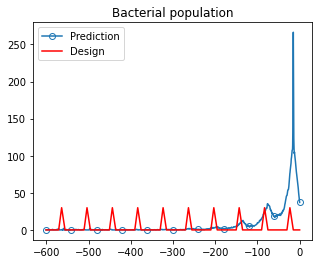

1400 0.05672209244221449 loss =  862977.0625
L_p, x1, x2, x3, h  =  60.09922790527344 -30.04961395263672 -23.282058715820312 -15.036154747009277 29.92926788330078


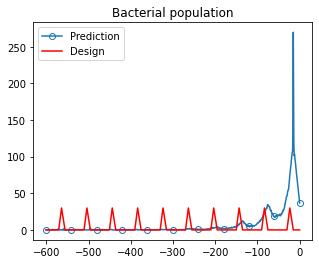

1600 0.05665009003132582 loss =  859766.6875
L_p, x1, x2, x3, h  =  60.09922790527344 -30.04961395263672 -23.527109146118164 -15.036263465881348 29.932125091552734


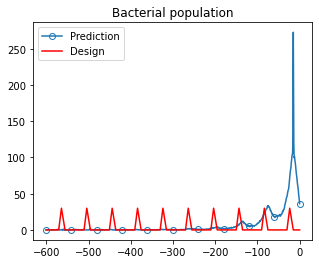

1800 0.0565897086635232 loss =  860544.25
L_p, x1, x2, x3, h  =  60.09922790527344 -30.04961395263672 -23.74757957458496 -15.036372184753418 29.91383171081543


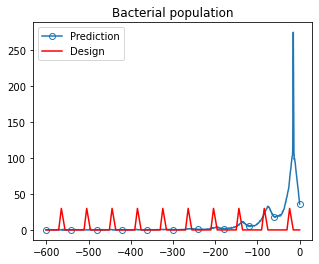

2000 0.0568015044555068 loss =  861200.5
L_p, x1, x2, x3, h  =  60.09922409057617 -30.049612045288086 -23.93149757385254 -15.03647518157959 29.947420120239258


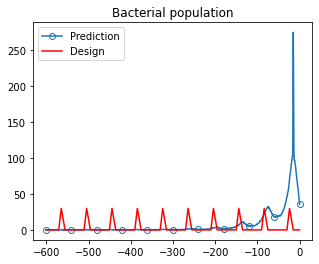

2200 0.05672395322471857 loss =  862039.25
L_p, x1, x2, x3, h  =  60.09922409057617 -30.049612045288086 -24.003925323486328 -15.036523818969727 29.957483291625977


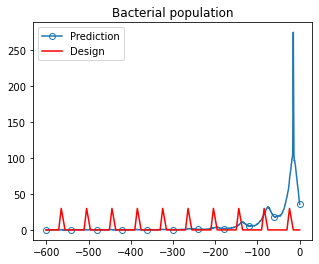

2400 0.056692251935601234 loss =  864174.375
L_p, x1, x2, x3, h  =  60.09922409057617 -30.049612045288086 -24.056148529052734 -15.036569595336914 29.9327392578125


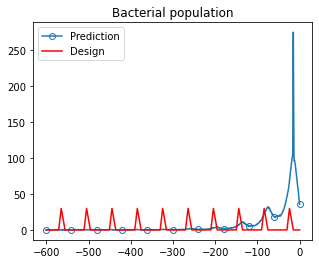

2600 0.05672075692564249 loss =  862188.25
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -24.08452033996582 -15.03661060333252 29.996910095214844


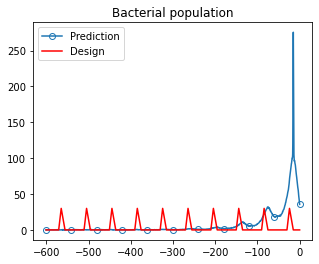

2800 0.05662187188863754 loss =  864608.875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -24.08247947692871 -15.036651611328125 29.937400817871094


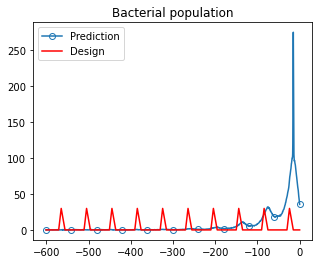

3000 0.05669012479484081 loss =  863224.8125
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -24.043235778808594 -15.036691665649414 29.948463439941406


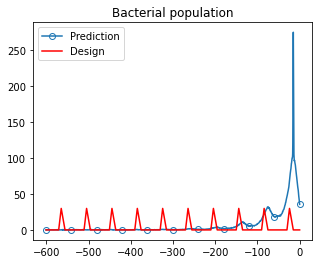

3200 0.05661747790873051 loss =  860725.9375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -24.005783081054688 -15.036710739135742 29.990201950073242


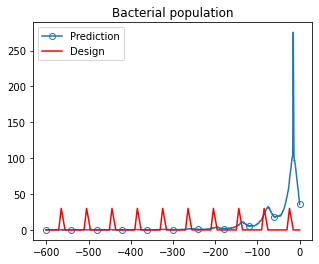

3400 0.05665803421288729 loss =  860779.0
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.955541610717773 -15.03672981262207 29.966506958007812


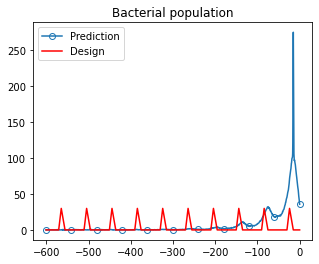

3600 0.05660479795187712 loss =  860588.375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.899629592895508 -15.036748886108398 29.9508113861084


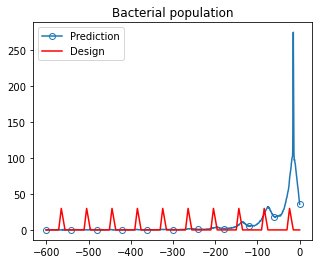

3800 0.05666803754866123 loss =  859449.375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.84259033203125 -15.036768913269043 29.96204376220703


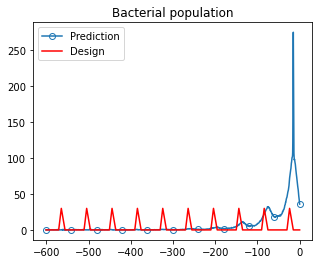

4000 0.05671220552176237 loss =  857460.0625
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.78676986694336 -15.036788940429688 29.999303817749023


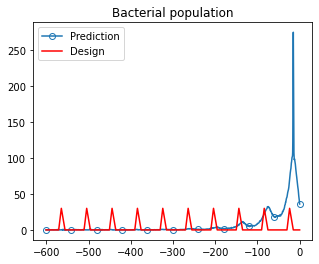

4200 0.05665845796465874 loss =  857889.5625
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.75986671447754 -15.036799430847168 29.9831600189209


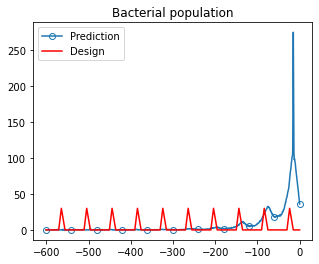

4400 0.05668865796178579 loss =  857972.4375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.733915328979492 -15.036808967590332 29.97688865661621


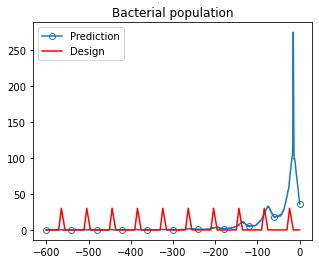

4600 0.056598556227982044 loss =  857641.75
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.708890914916992 -15.036819458007812 29.982267379760742


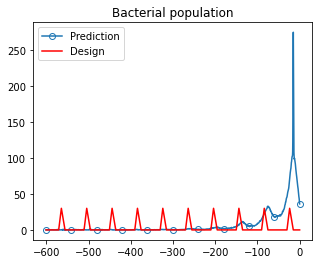

4800 0.05679236352443695 loss =  856953.75
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.684837341308594 -15.036829948425293 29.999454498291016


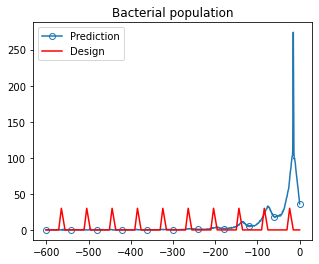

5000 0.05679885670542717 loss =  857546.3125
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.661897659301758 -15.036840438842773 29.983882904052734


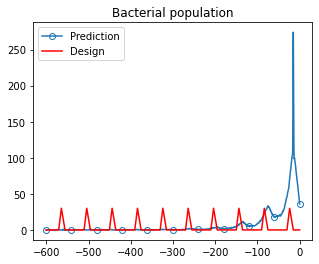

5200 0.05662798136472702 loss =  857672.5
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.650882720947266 -15.036845207214355 29.98067855834961


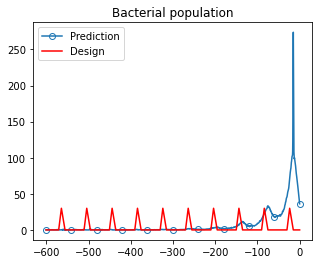

5400 0.05666546057909727 loss =  857599.8125
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.64021873474121 -15.036849975585938 29.98283576965332


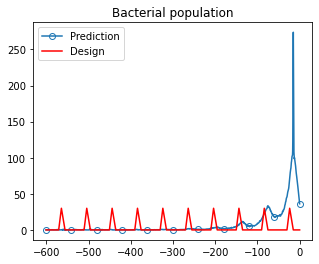

5600 0.056764496490359306 loss =  857313.1875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.62984275817871 -15.03685474395752 29.99068832397461


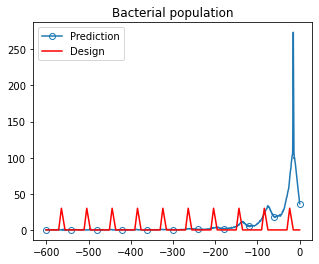

5800 0.05670675076544285 loss =  857049.375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.61969566345215 -15.036860466003418 29.997957229614258


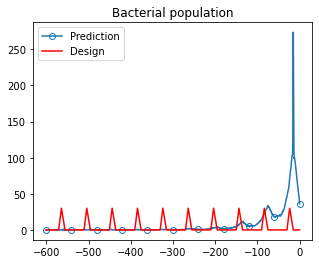

6000 0.05670158099383116 loss =  857382.8125
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.60972785949707 -15.036865234375 29.98944091796875


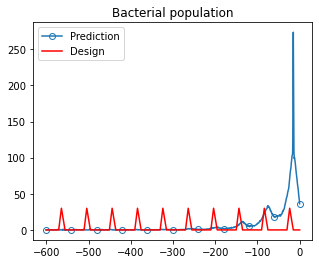

6200 0.05680911801755428 loss =  857471.9375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.604812622070312 -15.03686809539795 29.98723602294922


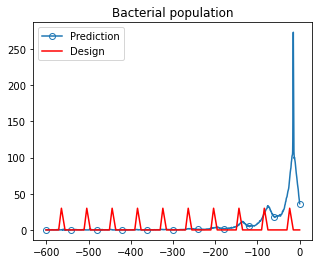

6400 0.0567019572481513 loss =  857485.5625
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.599964141845703 -15.036870002746582 29.987028121948242


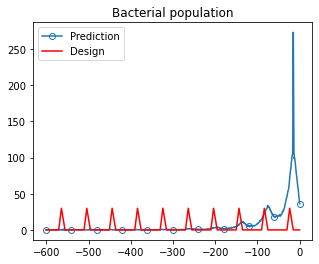

6600 0.05668003298342228 loss =  857411.75
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.595170974731445 -15.036872863769531 29.9891357421875


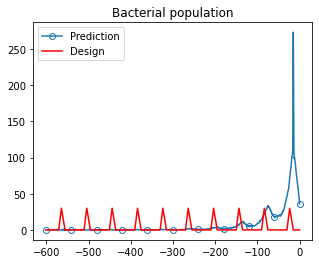

6800 0.05658671446144581 loss =  857254.6875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.590410232543945 -15.036874771118164 29.993450164794922


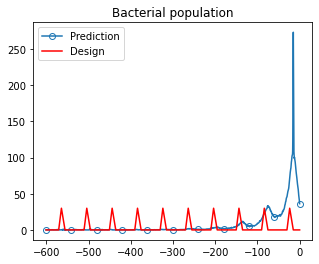

7000 0.05664687883108854 loss =  857050.75
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.58566665649414 -15.036877632141113 29.999004364013672


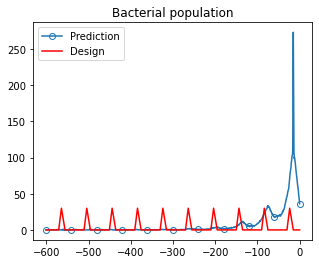

7200 0.05667461734265089 loss =  857080.875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.58329200744629 -15.03687858581543 29.998306274414062


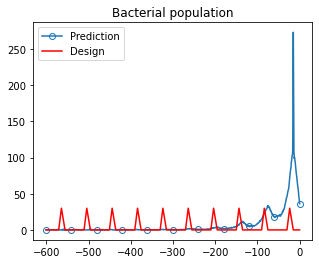

7400 0.0567936385050416 loss =  857153.75
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.58100128173828 -15.036879539489746 29.99648094177246


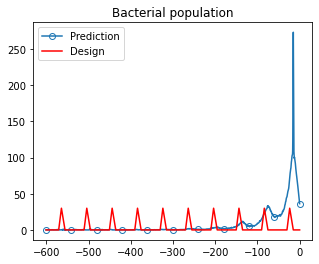

7600 0.05667311977595091 loss =  857200.9375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.578710556030273 -15.036880493164062 29.995328903198242


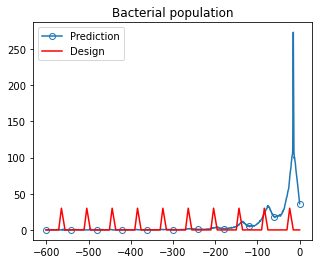

7800 0.056610723957419395 loss =  857223.875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.576417922973633 -15.036882400512695 29.994834899902344


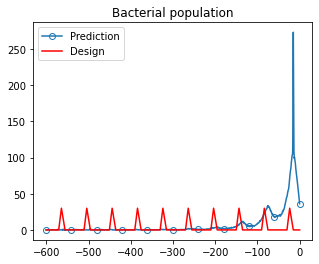

8000 0.05682263057678938 loss =  857217.75
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.574125289916992 -15.036883354187012 29.99510955810547


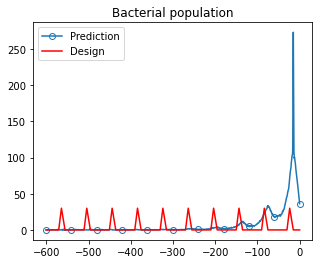

8200 0.05672899726778269 loss =  857198.0625
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.573026657104492 -15.036884307861328 29.995691299438477


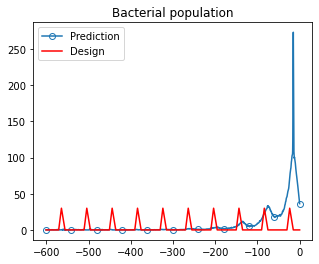

8400 0.05678011663258076 loss =  857162.0625
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.57192611694336 -15.036884307861328 29.996692657470703


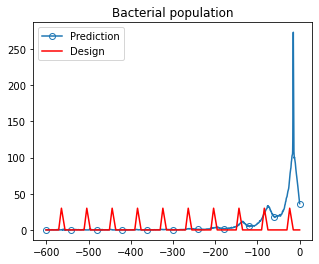

8600 0.056836857460439205 loss =  857116.6875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.570825576782227 -15.036885261535645 29.997953414916992


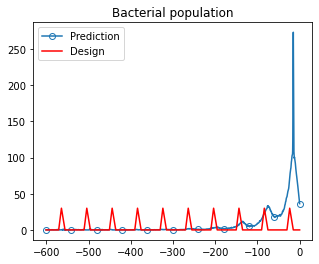

8800 0.05682631395757198 loss =  857068.1875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.56972312927246 -15.036885261535645 29.999309539794922


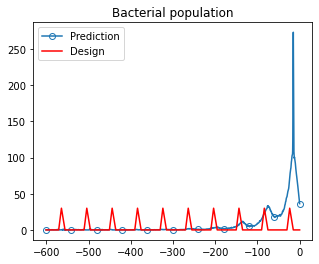

9000 0.056801014579832554 loss =  857068.4375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.568622589111328 -15.036886215209961 29.999380111694336


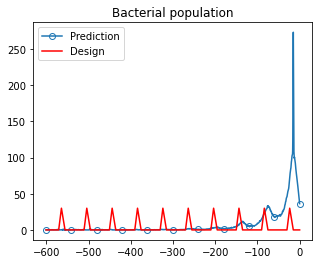

9200 0.05679954867810011 loss =  857088.6875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.568073272705078 -15.036886215209961 29.998878479003906


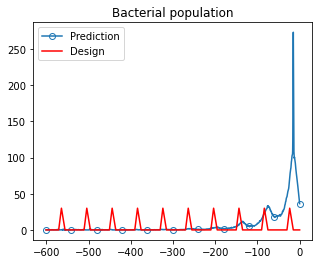

9400 0.056866140104830265 loss =  857104.5
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.567522048950195 -15.036887168884277 29.998498916625977


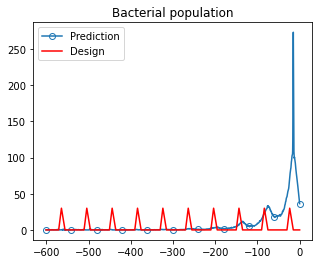

9600 0.0566767081618309 loss =  857116.6875
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.566970825195312 -15.036887168884277 29.99822235107422


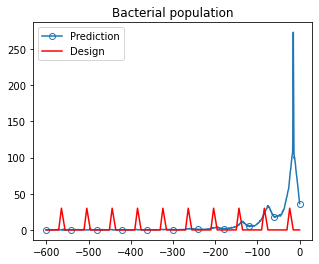

9800 0.056906091049313545 loss =  857124.4375
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.566421508789062 -15.036887168884277 29.998048782348633


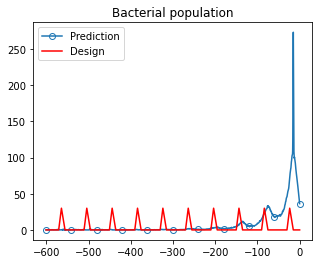

10000 0.0568696241825819 loss =  857128.25
L_p, x1, x2, x3, h  =  60.099220275878906 -30.049610137939453 -23.56587028503418 -15.036888122558594 29.99799156188965


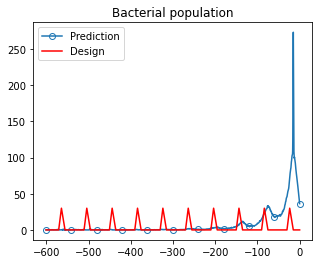

In [42]:
################################################################
# inverse optimization for 1d
################################################################
n_periods = 10

model = torch.load("catheter_plain_period_model_1d500", map_location=device)
print(count_params(model))

learning_rate = 0.0001
epochs = 10001
step_size = 1000
gamma = 0.5


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
def transfer(theta):
    
    L_p = 60 + (150 - 60)/(1 + torch.abs(theta[0]))
    x1 = -0.5*L_p
    x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
    h = 20   + (10)/(1 + torch.abs(theta[3]))
    return L_p, x1, x2, x3, h
   
def inv_transfer(L_p, x2, x3, h):
    theta = np.zeros(4)
    theta[0] = (150 - 60)/(L_p - 60) - 1
    theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
    theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
    theta[3] = 10/(h - 20 ) - 1
    return theta

sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
theta0 =    inv_transfer(L_p, x2, x3, h) 

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)



ncx = 200
n_periods = 10
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = Theta2Mesh_1d(L_p, x2, x3, h)
    
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    xx_mask = (torch.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)).to(device)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

In [ ]:
a = x.detach().cpu().numpy()
plt.plot(a[0,:,0], a[0,:,1])